#**AI GENERATED TEXT RECOGNITION TOOL**

---

SCC0633/SCC5908 - Natural Language Processing - 2024

Professor: Thiago A.S Pardo.

PAE Intern: Germano A. Z. Jorge

## **Group name: Generar**

* Jônatas Alves Lopes (11796552)
* Julio Cesar Galdino (15112607)
* Maria Victória Brandão Barros (12608692)
* Rebeca Vieira Carvalho (12543530)
* Thierry de Souza Araújo (12681094)

###Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.2 MB/s eta 0:00:00


In [4]:
from datasets import Dataset

In [5]:
pip install -U accelerate==0.30.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import accelerate

### Initial dataset exploration

In [6]:
data = pd.read_csv('/content/drive/MyDrive/BERT_data/AI_Human.csv')

In [ ]:
data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


The dataset is composed of two columns: the first one contains the texts for analysis, and the second one indicates the label for each text (1 for AI generated texts and 0 for human-written texts). The original dataset has 487235 observations, but we choose to use only a portion of the data for reasons of computational cost.

In [ ]:
data['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

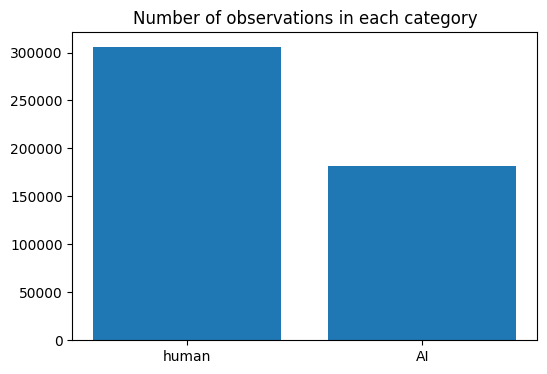

In [7]:
quant_dados = pd.DataFrame(data['generated'].value_counts()).reset_index()
plt.figure(figsize=(6,4))
plt.title('Number of observations in each category')
plt.bar(quant_dados['generated'], quant_dados['count'])
plt.xticks(quant_dados['generated'], ['human', 'AI'])
plt.show()

In [8]:
#selecting only a portion of the data
data_simplified = data.drop(data.index[150000:])

In [ ]:
data_simplified['generated'].value_counts()

generated
0.0    85336
1.0    64664
Name: count, dtype: int64

In the graph below we can see the data distribution for each category on the reduced dataset.

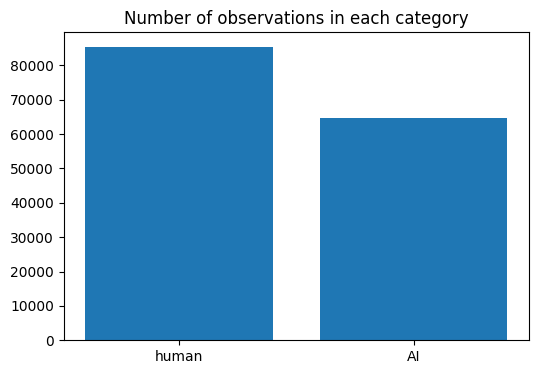

In [9]:
quant_dados = pd.DataFrame(data_simplified['generated'].value_counts()).reset_index()
plt.figure(figsize=(6,4))
plt.title('Number of observations in each category')
plt.bar(quant_dados['generated'], quant_dados['count'])
plt.xticks(quant_dados['generated'], ['human', 'AI'])
plt.show()

In [ ]:
del data

###Removing Stopwords

As part of the data preprocessing, we removed the stopwords using a NLTK function.

In [ ]:
#Removing stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

data_simplified['text_mod'] = data_simplified['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#saving the data
data_simplified.to_csv('/content/drive/MyDrive/BERT_data/data_simplified.csv')

In [ ]:
del data_simplified

###Train and test split

The data was split between train and test in a proportion of 70/30.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_simplified['text_mod'], data_simplified['generated'], test_size=0.3, random_state=42)

###BERT Tokenizer

We used BertTokenizer for this task. Since the model requires original data and tokenized data, we created a loop to ensure that the format of the dataset is correct.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
list_encoded = []
for row in range(x_train.shape[0]):
  texto = str(x_train.iloc[row])
  label = int(y_train.iloc[row])
  encode = tokenizer(texto, padding=True, truncation=True)
  encode['texto'] = texto
  encode['label'] = label
  list_encoded.append(encode)

In [ ]:
list_encoded_val = []
for row in range(x_val.shape[0]):
  texto = str(x_val.iloc[row])
  label = int(y_val.iloc[row])
  encode = tokenizer(texto, padding=True, truncation=True)
  encode['texto'] = texto
  encode['label'] = label
  list_encoded_val.append(encode)

In [ ]:
#saving the data
with open('/content/drive/MyDrive/BERT_data/token/list_encoded.pickle', 'wb') as file:
    pickle.dump(list_encoded, file)

In [ ]:
#saving the data
with open('/content/drive/MyDrive/BERT_data/token/list_encoded_val.pickle', 'wb') as file:
    pickle.dump(list_encoded_val, file)

In [ ]:
with open('/content/drive/MyDrive/BERT_data/token/list_encoded_val.pickle', 'rb') as file:
    list_encoded_val = pickle.load(file)

In [ ]:
with open('/content/drive/MyDrive/BERT_data/token/list_encoded.pickle', 'rb') as file:
    list_encoded = pickle.load(file)

In [ ]:
#trasforming the lists in Datasets (format required fot the model)
eval_dataset = Dataset.from_list(list_encoded_val)
train_dataset = Dataset.from_list(list_encoded)

###Model

The selected model is the BertForSequenceClassification, a pre-trained BERT model for classification. On this step, we defined the training parameters and trained the model.

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#training parameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.008700,0.008745


TrainOutput(global_step=6563, training_loss=0.029722154013325525, metrics={'train_runtime': 10234.8471, 'train_samples_per_second': 10.259, 'train_steps_per_second': 0.641, 'total_flos': 2.664206635476096e+16, 'train_loss': 0.029722154013325525, 'epoch': 1.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/BERT_data/my_model/model")
model.save_pretrained('/content/drive/MyDrive/BERT_data/my_model')
tokenizer.save_pretrained('/content/drive/MyDrive/BERT_data/my_model')


('/content/drive/MyDrive/BERT_data/my_model_2/tokenizer_config.json',
 '/content/drive/MyDrive/BERT_data/my_model_2/special_tokens_map.json',
 '/content/drive/MyDrive/BERT_data/my_model_2/vocab.txt',
 '/content/drive/MyDrive/BERT_data/my_model_2/added_tokens.json')

In [ ]:
trainer.save_model("/content/drive/MyDrive/BERT_data/my_model_model")

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.007941235788166523, 'eval_runtime': 1200.4762, 'eval_samples_per_second': 37.485, 'eval_steps_per_second': 4.686, 'epoch': 1.0}


The final result has a validation loss of only 0.0079, meaning the model is able to classify the data in a satisfactory way. With better computational capacity and more data (since only a fraction of the original dataset was used), it would be interesting to have a in-depth observation of the metrics variation throughout the epochs. In conclusion, the BERT model used is associated with a high computational cost, but seems to be efficient for this task.